In [247]:
# https://www.kaggle.com/humananalog/binary-image-classifier-training-demo

In [248]:
import os
import sys
from PIL import Image
import pandas as pd
import cv2

In [249]:
import numpy as np

In [250]:
import torchvision.transforms as transforms
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [251]:
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler
import torchvision.models as models

In [252]:
from tqdm.notebook import tqdm #this import is just a progress bar lol

In [253]:
import matplotlib.pyplot as plt

In [254]:
from torch.utils.tensorboard import SummaryWriter


In [255]:
#checking for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


In [256]:
image_size = 64
batch_size = 32

In [257]:
# No need to set transform normalization values for CPU execution
# You can remove or comment out the normalization part of the transform
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

In [258]:
data_path = 'D://major_project//one//Identifying-Human-Edited-Images-master//data//real_and_fake_face_detection//real_and_fake_face'
dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)

In [259]:
# creating data indices for training and validation splits
# https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
validation_split = 0.1
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

shuffle_dataset = True

if shuffle_dataset:
    np.random.seed(42)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [260]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)

In [261]:
# Update the data loaders to use num_workers=0 for CPU execution
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=0,  # Change this to 0 for CPU
    sampler=train_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=0,  # Change this to 0 for CPU
    sampler=validation_sampler
)

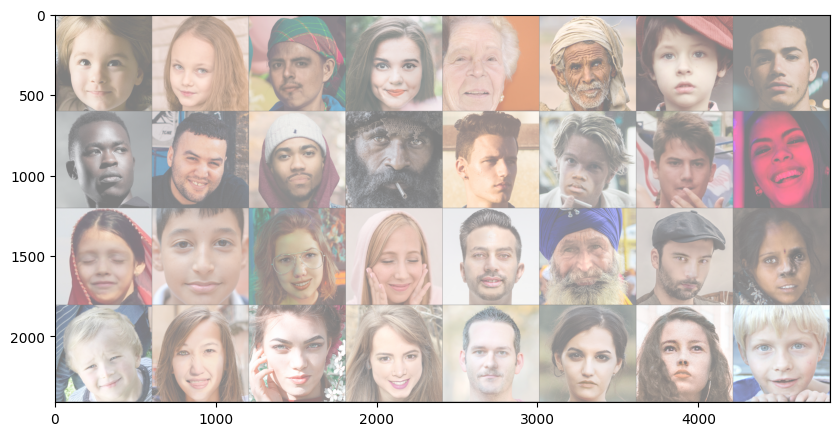

In [262]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(images))

In [263]:
# https://www.kaggle.com/humananalog/binary-image-classifier-training-demo
from torchvision.transforms import Normalize

class Unnormalize:
    """Converts an image tensor that was previously Normalize'd
    back to an image with pixels in the range [0, 1]."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        mean = torch.as_tensor(self.mean, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        std = torch.as_tensor(self.std, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        return torch.clamp(tensor*std + mean, 0., 1.)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)
unnormalize_transform = Unnormalize(mean, std)

In [264]:
X, y = next(iter(train_loader))

tensor(1)


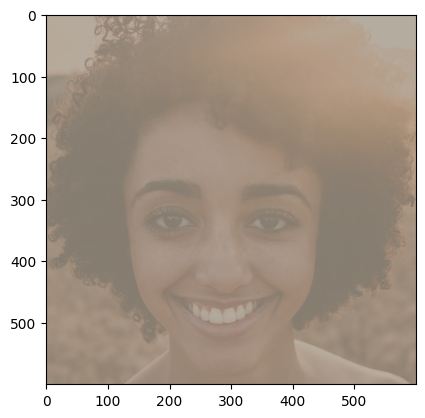

In [265]:
plt.imshow(unnormalize_transform(X[0]).permute(1, 2, 0))
# plt.imshow(X[0].permute(1, 2, 0))
print(y[0])

In [266]:
def evaluate(net, data_loader):
    net.train(False)
    
    bce_loss = 0
    total_examples = 0
    
    for batch_idx, data in enumerate(data_loader):
        with torch.no_grad():
            batch_size = data[0].shape[0]
            x = data[0]
            y_true = data[1].float()
            
            y_pred = net(x)
            y_pred = y_pred.squeeze()
            
            bce_loss += F.binary_cross_entropy_with_logits(y_pred, y_true).item() * batch_size
        
        total_examples += batch_size
    
    bce_loss /= total_examples
    print("BCE: %.4f" % (bce_loss))


In [267]:
def fit(epochs):
    global history, lr  # Add lr to the global variables
    
    history = {"train_bce": [], "val_bce": []}
    iteration = 0
    epochs_done = 0  # Define epochs_done here
    
    for epoch in range(epochs):
        print("Epoch %d" % (epochs_done + 1))
        
        bce_loss = 0
        total_examples = 0
        
        net.train(True)
        
        for batch_idx, data in enumerate(train_loader):
            batch_size = data[0].shape[0]
            
            x = data[0]
            y_true = data[1].float()
            
            optimizer.zero_grad()
            
            y_pred = net(x)
            y_pred = y_pred.squeeze()
            
            loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
            
            loss.backward()
            optimizer.step()
            
            batch_bce = loss.item()
            bce_loss += batch_bce * batch_size
            history["train_bce"].append(batch_bce)
            
            total_examples += batch_size
            iteration += 1
        
        bce_loss /= total_examples
        epochs_done += 1
        
        print("Epoch: %3d, train BCE: %.4f" % (epochs_done, bce_loss))
        
        val_bce_loss = evaluate(net, validation_loader)
        history["val_bce"].append(val_bce_loss)
        print("val BCE: %.4f" % (val_bce_loss))
        print()


In [268]:
# Assuming you want to use the first GPU if available, otherwise use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [269]:

resnext50_32x4d = models.resnext50_32x4d(pretrained=True)

In [270]:
resnext50_32x4d.fc = nn.Linear(2048,1)

In [271]:
net = resnext50_32x4d.to(device)

In [272]:
out = net(torch.zeros((10, 3, image_size, image_size)).to(device))
out.shape

torch.Size([10, 1])

In [273]:
# Freezing the early layers of the model
def freeze_until(net, param_name):
    found_name = False
    for name, params in net.named_parameters():
        if name == param_name:
            found_name = True
        params.requires_grad = found_name

In [274]:
freeze_until(net, "layer4.0.conv1.weight")

In [275]:
# train these layers
[k for k,v in net.named_parameters() if v.requires_grad]

['layer4.0.conv1.weight',
 'layer4.0.bn1.weight',
 'layer4.0.bn1.bias',
 'layer4.0.conv2.weight',
 'layer4.0.bn2.weight',
 'layer4.0.bn2.bias',
 'layer4.0.conv3.weight',
 'layer4.0.bn3.weight',
 'layer4.0.bn3.bias',
 'layer4.0.downsample.0.weight',
 'layer4.0.downsample.1.weight',
 'layer4.0.downsample.1.bias',
 'layer4.1.conv1.weight',
 'layer4.1.bn1.weight',
 'layer4.1.bn1.bias',
 'layer4.1.conv2.weight',
 'layer4.1.bn2.weight',
 'layer4.1.bn2.bias',
 'layer4.1.conv3.weight',
 'layer4.1.bn3.weight',
 'layer4.1.bn3.bias',
 'layer4.2.conv1.weight',
 'layer4.2.bn1.weight',
 'layer4.2.bn1.bias',
 'layer4.2.conv2.weight',
 'layer4.2.bn2.weight',
 'layer4.2.bn2.bias',
 'layer4.2.conv3.weight',
 'layer4.2.bn3.weight',
 'layer4.2.bn3.bias',
 'fc.weight',
 'fc.bias']

In [276]:
# Pretest of the model
evaluate(net, validation_loader)

BCE: 0.6939


In [277]:
# Define the initial learning rate
initial_lr = 0.01

# Create an optimizer with the initial learning rate
optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

In [278]:
# Define a learning rate scheduler (e.g., StepLR) to reduce the learning rate
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Define the number of epochs
num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}, Learning Rate: {scheduler.get_lr()}")
    
    # Train your model here
    
    # Update the learning rate using the scheduler
    scheduler.step()

Epoch 1, Learning Rate: [0.01]
Epoch 2, Learning Rate: [0.01]
Epoch 3, Learning Rate: [0.01]
Epoch 4, Learning Rate: [0.01]
Epoch 5, Learning Rate: [0.01]
Epoch 6, Learning Rate: [0.01]
Epoch 7, Learning Rate: [0.01]
Epoch 8, Learning Rate: [0.01]
Epoch 9, Learning Rate: [0.01]
Epoch 10, Learning Rate: [0.01]
Epoch 11, Learning Rate: [0.0001]
Epoch 12, Learning Rate: [0.001]
Epoch 13, Learning Rate: [0.001]
Epoch 14, Learning Rate: [0.001]
Epoch 15, Learning Rate: [0.001]
Epoch 16, Learning Rate: [0.001]
Epoch 17, Learning Rate: [0.001]
Epoch 18, Learning Rate: [0.001]
Epoch 19, Learning Rate: [0.001]
Epoch 20, Learning Rate: [0.001]


In [279]:
# Modify the learning rate annealing
def set_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [280]:
from tensorboardX import SummaryWriter
# Create a TensorBoard SummaryWriter
writer = SummaryWriter(log_dir='./logs')


In [281]:
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}, Learning Rate: {scheduler.get_lr()}")
    
    # Train your model here
    
    # Update the learning rate using the scheduler
    scheduler.step()
    
    # Manually adjust the learning rate (if needed)
    lr /= 10
    set_lr(optimizer, lr)

    # Log training loss to TensorBoard
    writer.add_scalar('Train Loss', bce_loss, iteration)
    
    # Optionally, you can call your custom fit function here (fitting for 1 epoch)
    # fit(1)

Epoch 1, Learning Rate: [1e-05]
Epoch 2, Learning Rate: [1.000000000000001e-105]
Epoch 3, Learning Rate: [1.0000000000000009e-106]
Epoch 4, Learning Rate: [1.0000000000000009e-107]
Epoch 5, Learning Rate: [1.000000000000001e-108]
Epoch 6, Learning Rate: [1.0000000000000009e-109]
Epoch 7, Learning Rate: [1.000000000000001e-110]
Epoch 8, Learning Rate: [1.000000000000001e-111]
Epoch 9, Learning Rate: [1.000000000000001e-112]
Epoch 10, Learning Rate: [1.000000000000001e-113]
Epoch 11, Learning Rate: [1.000000000000001e-115]
Epoch 12, Learning Rate: [1.000000000000001e-115]
Epoch 13, Learning Rate: [1.000000000000001e-116]
Epoch 14, Learning Rate: [1.0000000000000009e-117]
Epoch 15, Learning Rate: [1.0000000000000009e-118]
Epoch 16, Learning Rate: [1.0000000000000008e-119]
Epoch 17, Learning Rate: [1.0000000000000008e-120]
Epoch 18, Learning Rate: [1.0000000000000008e-121]
Epoch 19, Learning Rate: [1.0000000000000009e-122]
Epoch 20, Learning Rate: [1.0000000000000009e-123]


In [282]:

checkpoint = { "optimizer": optimizer.state_dict(),
               "model": net.state_dict() }
torch.save(checkpoint, "checkpoint.pth")

In [283]:
writer = SummaryWriter()

In [284]:
tf = transforms.Compose([transforms.ToTensor(),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])

In [285]:
# testing
def classify_fake(model,img_path):
    im_w, im_h = Image.open(img_path).size
    
    face = Image.open(img_path).convert('RGB')
    face_tens = tf(face).to(device) 
    
    with torch.no_grad():
        prob = model(face_tens.unsqueeze(0))[0]
#         print(prob)
        prob = prob.sigmoid().cpu().item()
    
    return prob

In [286]:
# testimage
TEST_IMAGE_PATH = 'D://major_project//one//Identifying-Human-Edited-Images-master//data//real_and_fake_face//training_fake//easy_4_0011.jpg'

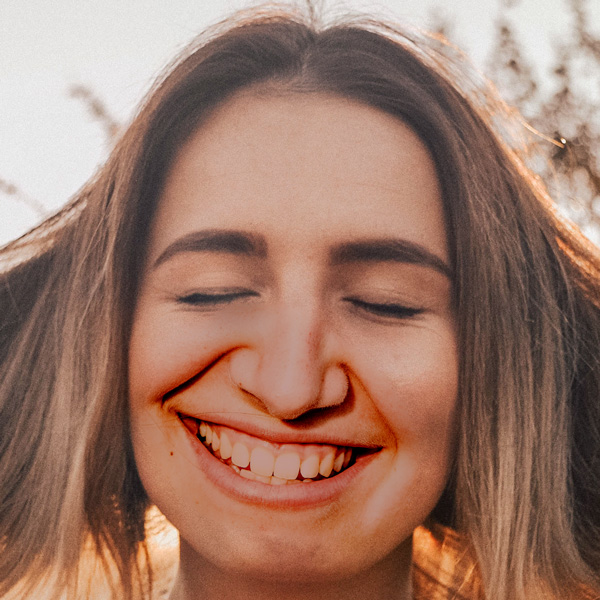

In [287]:
im1 = Image.open(TEST_IMAGE_PATH)
im1

In [288]:
classify_fake(net,TEST_IMAGE_PATH)

0.5624475479125977

In [289]:
TEST_IMAGE_PATH_2 = 'D://major_project//one//Identifying-Human-Edited-Images-master//data//real_and_fake_face//training_real//real_00015.jpg'

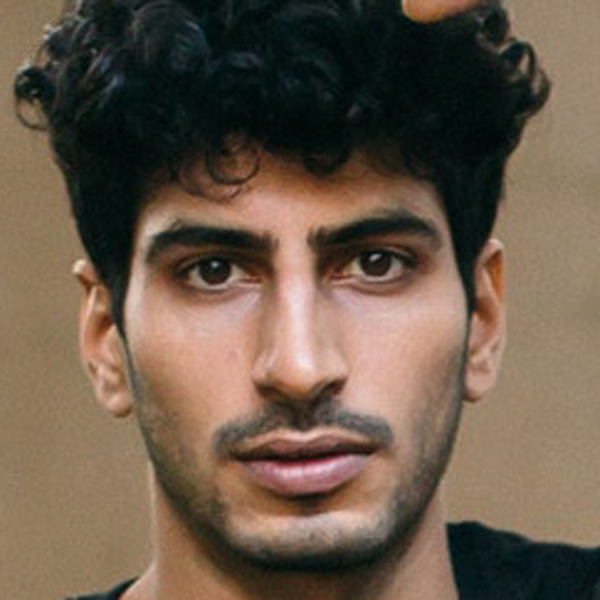

In [290]:
im2 = Image.open(TEST_IMAGE_PATH_2)
im2

In [291]:
classify_fake(net,TEST_IMAGE_PATH_2)

0.5602123737335205